# CancerNet

[Kaggle Breast IDC dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

After working through lesson1, I decided to test the applicability of the model trained to recognized different dog species on breast cancer images. The dataset consists of 277524 images of size (50,50) with a roughly 71:29 negative positive split

Each image in the dataset comes from 162 whole mount slide images scanned at 40x and each image gives us the patient ID, x and y co-ordinates of the patch from the original image as well as the target class for that patch

I'll first try out the model as is from lesson1 and then tune it to for this dataset. The idea is to learn what works and what doesn't for medical imaging with a lot of experimentation in between

## Load up the required libraries and jupyter setup commands

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.metrics import *
import glob
from shutil import copyfile, copy, move

The first step is to download and de-compress the data. Make sure to setup the Kaggle API. The instructions can be found [here](https://github.com/Kaggle/kaggle-api)

*kaggle datasets download -d paultimothymooney/breast-histopathology-images*

After running the above command in the terminal, the raw dataset should be downloaded in the filesystem

*unzip -q breast-histopathology-images.zip*

*unzip -q IDC_regular_ps50_idx5.zip -d histopath*

## Set up the Pathlib variables for easier path manipulation

[pathlib](https://docs.python.org/3/library/pathlib.html) is an excellent abstraction for representing file paths allowing for more cleaner and readable code

_Modify source directory as per your filesystem path_

In [3]:
path = Path('/home/jupyter/tutorials/histopath')
train = path/'train'
test = path/'test'
valid = path/'valid'

In [4]:
def get_split(files):
    """Returns the input as a train/test split
    
    Input: 
        files: List of filenames
    
    Output: Lists of train and test filenames
    """
    n_files = len(files)
    
    n_test = round(test_split * n_files)
    test = files[:n_test]
    
    temp = files[n_test:]
    n_valid = round(valid_split * n_files)
    random.shuffle(temp)

    valid = temp[:n_valid]
    train = temp[n_valid:]
    
    return train, valid, test

In [5]:
def shuffle(input_list, flag):
    """Helper function specifically for train and valid folder shuffle
    
    Input: 
        input_list: either one of train or valid split list
        flag: either one of train/valid path variable defined above
    
    Output: Files from input_list are moved into respective folders
    """
    
    for i in range(len(input_list)):
        filename = input_list[i].stem + '.png'
        label = str(input_list[i]).split("_")[4].split(".")[0]
        if (label == "class0"):
            os.rename(input_list[i], flag/'0'/filename)
        else:
            os.rename(input_list[i], flag/'1'/filename)

In [6]:
def shuffle_data(train_list, valid_list, test_list):
    """ Shuffle the data into train and test folders
    The data is moved/copied into the proper directory 
    with the proper label on the basis of the filename
    
    Input: 
        List of train, valid and test set filenames
    
    Output: Files from original dataset are moved into the appropriate
    train/test folders
    """
    
    # Train and Valid split
    shuffle(train_list, train)
    shuffle(valid_list, valid)
    
    #Test split
    for i in range(len(test_list)):
        file = str(test_list[i].stem) + '.png'
        os.rename(test_list[i], test/file)

In [7]:
def get_data(filenames):
    train_set, valid_set, test_set = get_split(filenames)
    
    #Sum of train and test split should add up to the total number of images in our dataset
    print(len(train_set), len(test_set), len(valid_set))

    %time shuffle_data(train_set, valid_set, test_set)

## Create list of filenames and shuffle the data into appropriate folders

First, let's get a list of filenames that we'll then split into train, valid and test sets. 

The next step is to shuffle the data into the respective folders based on the split lists

#### Organize data into train, valid and test folders

This shuffling will be done on the split defined above

**Ensure that this is run only once.** Alternatively, use _shutil.copy_ instead of _os.rename_ if you want to run this code cell more than once

Also, make sure that the train, valid and test folders alongwith the respective label folders(for train and valid) have been created

In [152]:
filenames = list(path.rglob('*.png'))

#Alternatively
#files = get_files(path, recurse=True)

np.random.seed(42)
np.random.shuffle(filenames)

In [153]:
test_split = 0.2
valid_split = 0.3

In [154]:
get_data(filenames)

138762 55505 83257
CPU times: user 3.77 s, sys: 5.2 s, total: 8.96 s
Wall time: 2min 59s


## Default Training

Let's look at a model using default fastai hyperparameters for transforms and learning rates and then we'll look at hyperparameter tuning to get a better model

In [8]:
tfms = get_transforms()

### Create a DataBunch

Rather than using ImageDataBunch.from_folder, let's create out databunch using the DataBlock API which is more flexible. Underneath, the ImageDataBunch class calls the DataBlock API. For cases when the data is not structured as the factory methods expect it, DataBlock is the first thing you should try

_data = ImageDataBunch.from_folder(path, train, valid, ds_tfms = tfms, bs=64, size=50).normalize()_

[DataBlock](https://docs.fast.ai/data_block.html)

[ImageDataBunch.from_folder](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder)

[show_batch](https://docs.fast.ai/basic_data.html#DataBunch.show_batch)

In [9]:
data = (ImageItemList.from_folder(path)
.split_by_folder()
.label_from_folder()
.add_test_folder()
.transform(tfms, size=50)
.databunch(bs=64).normalize())

In [10]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (138762 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /home/jupyter/tutorials/histopath
x: ImageItemList (138762 items)
[Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50)]...
Path: /home/jupyter/tutorials/histopath;

Valid: LabelList
y: CategoryList (83257 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /home/jupyter/tutorials/histopath
x: ImageItemList (83257 items)
[Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50)]...
Path: /home/jupyter/tutorials/histopath;

Test: LabelList
y: EmptyLabelList (55505 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (55505 items)
[Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50)]...
Path: /home/jupyter/tutorials/histopath

In [11]:
data.c, data.classes

(2, ['0', '1'])

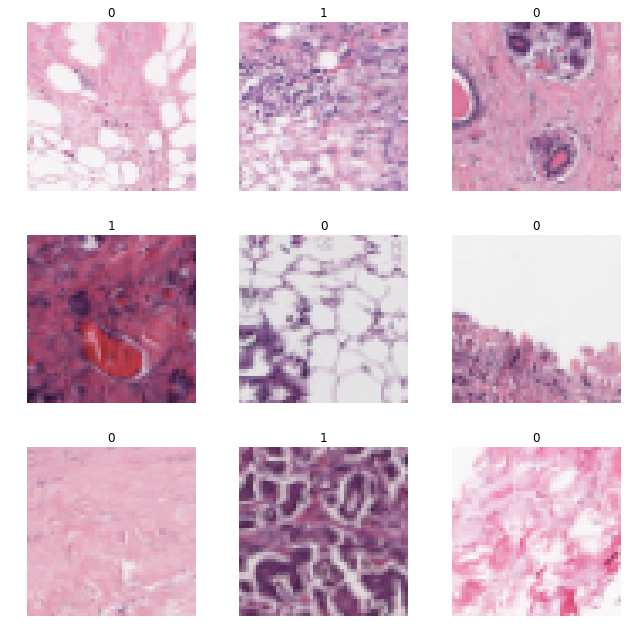

In [12]:
data.show_batch(3, figsize=(9, 9))

In [13]:
learn = create_cnn(data, models.resnet34, metrics = accuracy)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [14]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

In [179]:
learn.save('stage-1', path)

PosixPath('/home/jupyter/tutorials/histopath/models/stage-1.pth')

## Results

Use ClassificationIntepretation to visualize the results

In [180]:
interpret = ClassificationInterpretation.from_learner(learn)

I'm no expert when it comes to medical imaging or breast cancer for that matter. So I'm just going to stick to a confusion matrix for interpretation rather than plotting the top losses

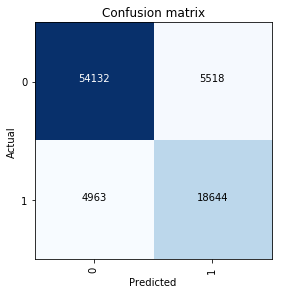

In [181]:
interpret.plot_confusion_matrix()

Let's continue training our model to make it better, iteratively

Unfreezing the layers basically makes the entire network available for training rather than just the final layers that fastai library adds upon loading the pre-trained model

For more info on 1-Cycle Policy, [this](https://sgugger.github.io/the-1cycle-policy.html) is an excellent resource

*From here on out, it's all about experimentation*. There's defined way to do this, just needs intuition and practice which will get better over time

In [182]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.287687,0.291034,0.881343


In [ ]:
learn.load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


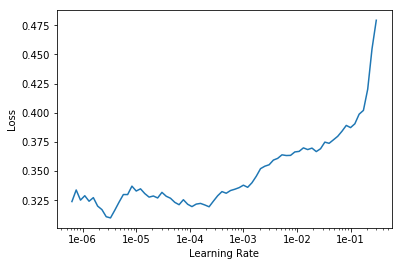

In [184]:
learn.lr_find()
learn.recorder.plot()

In [185]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-6)

epoch,train_loss,valid_loss,accuracy
1,0.312423,0.295279,0.877127
2,0.323882,0.294895,0.877103


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


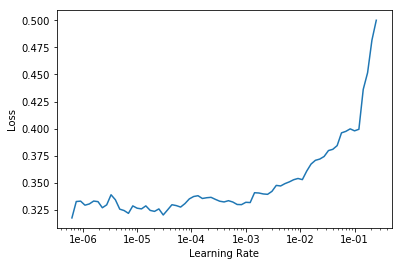

In [186]:
learn.lr_find()
learn.recorder.plot()

In [187]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.303718,0.289087,0.879205


In [188]:
learn.save('stage-2', path)

PosixPath('/home/jupyter/tutorials/histopath/models/stage-2.pth')

In [ ]:
learn.load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


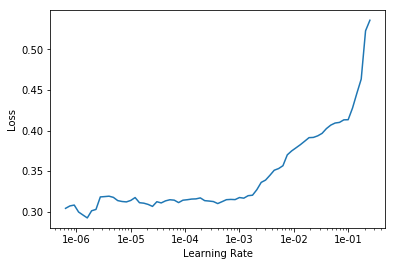

In [190]:
learn.lr_find()
learn.recorder.plot()

In [191]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.281427,0.285148,0.882064


In [192]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.277751,0.262840,0.889931


In [193]:
learn.save('stage-3', path)

PosixPath('/home/jupyter/tutorials/histopath/models/stage-3.pth')

In [194]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


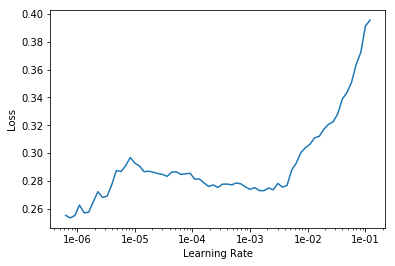

In [195]:
learn.lr_find()
learn.recorder.plot()

In [196]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.272947,0.269645,0.886796


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


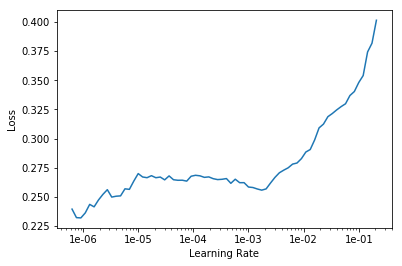

In [197]:
learn.lr_find()
learn.recorder.plot()

In [198]:
learn.fit_one_cycle(1, 1e-6)

epoch,train_loss,valid_loss,accuracy
1,0.264066,0.271576,0.885523


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


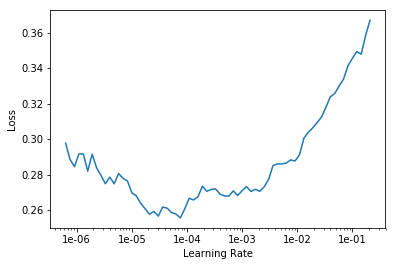

In [199]:
learn.lr_find()
learn.recorder.plot()

In [200]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,accuracy
1,0.254001,0.263734,0.888574


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


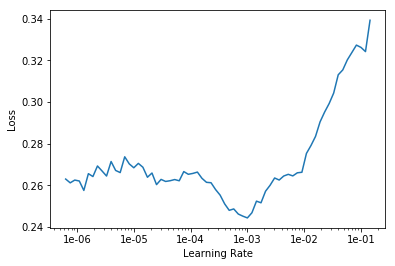

In [201]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [202]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.259394,0.261125,0.890664


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


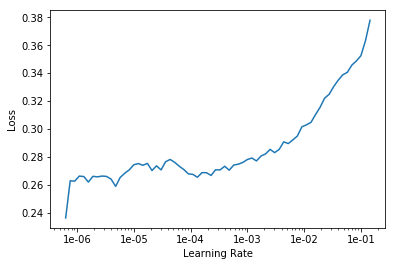

In [160]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load('stage-3')

In [204]:
learn.unfreeze()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy
1,0.281729,0.309637,0.867447
2,0.254803,0.262935,0.890400


In [205]:
learn.save('stage-4', path)

PosixPath('/home/jupyter/tutorials/histopath/models/stage-4.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


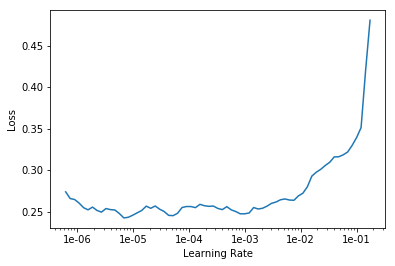

In [206]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [207]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.257330,0.267659,0.889451


In [ ]:
learn.load('stage-4')

In [209]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.255216,0.259559,0.890964


Let's consider this the baseline model that we'll compare our experiments on

Possible experiments include:
    1. ResNet50
    2. DenseNet101
    3. Data Augmentation using get_transforms()

## Let's start with Data Augmentation

In [15]:
tfms =  get_transforms(flip_vert = True, max_rotate = 4., max_zoom = 1.2, max_warp = 0.)

In [16]:
data = (ImageItemList.from_folder(path)
.split_by_folder()
.label_from_folder()
.add_test_folder()
.transform(tfms, size=49)
.databunch(bs=64).normalize())

In [17]:
learn = create_cnn(data, models.resnet34, metrics = accuracy)

In [18]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy
1,0.338228,0.319989,0.864960
2,0.318254,0.297241,0.874029


In [19]:
learn.save('aug-stage1', path)

PosixPath('/home/jupyter/tutorials/histopath/models/aug-stage1.pth')

In [20]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.279013,0.262737,0.891649


In [21]:
learn.save('aug-stage2', path)

PosixPath('/home/jupyter/tutorials/histopath/models/aug-stage2.pth')

In [22]:
learn.load('aug-stage1')

learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.296161,0.263374,0.891180


In [23]:
learn.save('aug-stage3', path)

PosixPath('/home/jupyter/tutorials/histopath/models/aug-stage3.pth')

In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.274526,0.255228,0.894627


In [25]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy
1,0.298218,0.272500,0.886544
2,0.268118,0.247796,0.898255


In [26]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.254357,0.246990,0.898651


In [27]:
learn.save('aug-stage4', path)

PosixPath('/home/jupyter/tutorials/histopath/models/aug-stage4.pth')

In [28]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy
1,0.280192,0.258328,0.892754
2,0.262613,0.239575,0.900501


In [31]:
learn.save('final', path)

PosixPath('/home/jupyter/tutorials/histopath/models/final.pth')

In [30]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy
1,0.285960,0.252830,0.895889
2,0.256151,0.234305,0.903311


In [32]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.242382,0.236387,0.902771


Our model is now at a decent accuracy. As you can see, there's potential to minimize the loss even further but for the purpose of this tutorial, we'll stop here

Feel free to continue any more experiments and change the transforms, batch size and a number of other possible hyper parameters

In [ ]:
learn.load('final')

In [35]:
learn.export('final.pkl')

The line above will export the minimum state of the model for inference and deployment